# GetAtmFromTime
=============================


The purpose is to get the atmospheric properties from any UTC time.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

# Configuration

## MERRA-2 datafile

In [3]:
file_merra2='MERRA2_2017_M2I1NXASM_M2T1NXAER_M2T1NXRAD_ctio_AllYear.csv'
df_merra2=pd.read_csv(file_merra2,index_col=0)
df_merra2.index.name='time'
# convert the string into timestamp
#-------------------------------------
all_datetime_merra2=pd.to_datetime(df_merra2.index.get_values())

## CTIO data logbook file

In [20]:
file_logbook_ctio='ctiofulllogbook_jun2017_v4.csv'
df_ctio=pd.read_csv(file_logbook_ctio,sep=';')
df_ctio=df_ctio.reindex(columns=['date','P','T','RH','airmass','seeing','exposure','object','filter','disperser',
                                 'focus','W','subdir','file']).set_index('date').sort_index()
# convert the string into timestamp
#-------------------------------------
all_datetime_ctio=pd.to_datetime(df_ctio.index.get_values())

# Definition of time

In [5]:
# remove data_26may because all times are creazy time
# supressed'data_26may17'
all_subdirs=['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17']

In [6]:
NB_SUBDIRS=len(all_subdirs)

## quality flag

In [7]:
flag_photometric_nights=[False,False,True,False,False,False,False,False,False,True,False,True,True,False]

# Selection of a night

In [8]:
subdir_sel_idx=2

In [9]:
df_ctio_subdir=df_ctio[df_ctio["subdir"]==all_subdirs[subdir_sel_idx]]

In [10]:
def GetStartStoptime(df_ctio_subdir):
    """
    Retrieve the start and stop time of a subdir dataset
    input: df_ctio_subdir dataset of CTIO data
    output:
        start_time
        stop_time
    """
    all_datetime_ctio_subdir=pd.to_datetime(df_ctio_subdir.index.get_values())
    start_time=all_datetime_ctio_subdir[0]
    stop_time=all_datetime_ctio_subdir[-1]
    return start_time,stop_time
    

In [11]:
GetStartStoptime(df_ctio_subdir)

(Timestamp('2017-05-30 21:17:00.652000'),
 Timestamp('2017-05-31 10:42:16.450000'))

In [12]:
def GetAtmosphericParameters(timestamp0,df_merra2):
    """
    GetAtmosphericParameters(timestamp0,df_merra2) :
     return closest time atmospheric parameters from merra dataset at timestamp0
    
    input arg:
    - timestamp0 : timestamp of the CTIO image in pd.DateTime type
    - df_merra2  : pandas dataset holding all atmospheric parameters indexed by time
    
    where :
    "ps","pwv","ozone" are estimated every hours
    'TOTEXTTAU','TOTANGSTR','TOTSCATAU','TAUTOT','TAUHGH','TAUMID','TAULOW' are estimated ever hour at hour and a half 
    
    then  df_merra2 is split into two datasets in which there are no NA value.
    The estimated value the closest in time are returned
    
    return:
        - ps : presure in hPa from dataset1
        - pwv : Precipitable Water vapour in mm from dataset1
        - ozone : Ozone in Dobson Unit in dataset1 
        - aer   : vertical aerosol optical depth at 550 nm in dataset2
        - clouds : clouds in vertical depth
        - deltat1,deltat2  : time delay wrt timestamp
    
    """
    
    # decode the time form timestamp
    year0=timestamp0.year
    month0=timestamp0.month
    day0=timestamp0.days_in_month
    hour0=timestamp0.hour
    minu0=timestamp0.minute
    
    # remove NA in rows and split in 2 datasets, dataset1,dataset2 without NA 
    # datset1 with ps, pwv ozone 
    dataset1_m2=df_merra2.dropna(axis=0,how='all',subset=["ps","pwv","ozone"]).loc[:, 'ps':'ozone']
    # datset2 with aerosols and clouds
    dataset2_m2=df_merra2.dropna(axis=0,how='all',subset=['TOTEXTTAU','TOTANGSTR','TOTSCATAU','TAUTOT','TAUHGH','TAUMID','TAULOW']).loc[:,'TOTEXTTAU':'TAULOW']
    
    
    # convert the string into timestamp
    #-------------------------------------
    all_datetime1_m2=pd.to_datetime(dataset1_m2.index.get_values())
    all_datetime2_m2=pd.to_datetime(dataset2_m2.index.get_values())
    
   
    # get time difference between timestamp = timestamp-merra2-timestamp-ctio
    #---------------------------------------
    deltat1=(all_datetime1_m2-timestamp0).total_seconds()
    deltat2=(all_datetime2_m2-timestamp0).total_seconds()
    
    delays1=np.abs(deltat1)
    idx1=np.where(delays1==delays1.min())[0][0]
    
    delays2=np.abs(deltat2)
    idx2=np.where(delays2==delays2.min())[0][0]
    
    if False:
        print 'deltat1 :' ,deltat1[idx1], pd.Timedelta(deltat1[idx1],unit='s')
        print dataset1_m2.iloc[idx1,:]
        
        print 'deltat2 :' ,deltat2[idx2],pd.Timedelta(deltat2[idx2],unit='s')
        print dataset2_m2.iloc[idx2,:]
        
    ps=dataset1_m2.iloc[idx1]["ps"]/100. # convert Pa into hecto-Pa
    pwv=dataset1_m2.iloc[idx1]["pwv"]
    ozone=dataset1_m2.iloc[idx1]["ozone"]
    aer=dataset2_m2.iloc[idx2]["TOTEXTTAU"]
    clouds=dataset2_m2.iloc[idx2]["TAUTOT"]
    
    if False:
        print 'idx1=',idx1,' P=',ps,' pwv=',pwv,' ozone =',ozone
        print 'idx2=',idx2,' aer=',aer, ' , clouds = ',clouds
    
    return ps,pwv,ozone,aer,clouds,deltat1[idx1]/60.,deltat2[idx2]/60.                          

In [13]:
#df_merra2.dropna(axis=0,how='all',subset=["ps","pwv","ozone"]).loc[:, 'ps':'ozone']

In [14]:
#df_merra2.dropna(axis=0,how='all',subset=['TOTEXTTAU','TOTANGSTR','TOTSCATAU','TAUTOT','TAUHGH','TAUMID','TAULOW']).loc[:,'TOTEXTTAU':'TAULOW']

## convert ctio subdir into datatime

In [15]:
mydates=pd.to_datetime(df_ctio_subdir.index.get_values())

## select one

In [16]:
one_mydates=mydates[5]

In [17]:
one_mydates

Timestamp('2017-05-30 21:20:38.293000')

In [18]:
print GetAtmosphericParameters(one_mydates,df_merra2)

(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -20.638216666666668, 9.3617833333333333)


In [19]:
for thedate in mydates:
    print GetAtmosphericParameters(thedate,df_merra2)

(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -17.010866666666669, 12.989133333333335)
(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -17.73641666666667, 12.263583333333335)
(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -18.4618, 11.5382)
(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -19.187233333333335, 10.812766666666668)
(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -19.91286666666667, 10.087133333333334)
(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -20.638216666666668, 9.3617833333333333)
(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -21.363666666666671, 8.6363333333333347)
(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142, 0.0, -22.089200000000002, 7.9108000000000001)
(786.99164062499995, 4.40496873856, 253.77587890599997, 0.0308459550142,

(788.01773437500003, 4.0119881629899998, 256.54681396500001, 0.027201218530500001, 0.0, 11.16915, -18.830850000000002)
(788.01773437500003, 4.0119881629899998, 256.54681396500001, 0.027201218530500001, 0.0, 8.2958499999999997, -21.704150000000002)
(788.01773437500003, 4.0119881629899998, 256.54681396500001, 0.027201218530500001, 0.0, 6.4216000000000006, -23.578400000000002)
(788.01773437500003, 4.0119881629899998, 256.54681396500001, 0.027201218530500001, 0.0, 4.5491999999999999, -25.450800000000001)
(788.01773437500003, 4.0119881629899998, 256.54681396500001, 0.027201218530500001, 0.0, 2.6649500000000002, -27.335050000000003)
(788.01773437500003, 4.0119881629899998, 256.54681396500001, 0.0262509547174, 0.0, -0.20671666666666669, 29.793283333333338)
(788.01773437500003, 4.0119881629899998, 256.54681396500001, 0.0262509547174, 0.0, -3.0775333333333337, 26.922466666666669)
(788.01773437500003, 4.0119881629899998, 256.54681396500001, 0.0262509547174, 0.0, -4.9482500000000007, 25.051750000

(788.48093749999998, 4.5642976760900007, 257.28482055699999, 0.025329535827, 0.0, -19.480783333333331, 10.519216666666667)
(788.48093749999998, 4.5642976760900007, 257.28482055699999, 0.025329535827, 0.0, -21.354150000000001, 8.6458499999999994)
(788.48093749999998, 4.5642976760900007, 257.28482055699999, 0.025329535827, 0.0, -23.228433333333335, 6.7715666666666676)
(788.48093749999998, 4.5642976760900007, 257.28482055699999, 0.025329535827, 0.0, -25.101616666666668, 4.8983833333333333)
(788.48093749999998, 4.5642976760900007, 257.28482055699999, 0.025329535827, 0.0, -27.976733333333335, 2.0232666666666668)
(788.557734375, 4.8345103263900002, 257.99954223599997, 0.025329535827, 0.0, 29.148266666666668, -0.85173333333333345)
(788.557734375, 4.8345103263900002, 257.99954223599997, 0.025329535827, 0.0, 27.275100000000002, -2.7248999999999999)
(788.557734375, 4.8345103263900002, 257.99954223599997, 0.025329535827, 0.0, 25.403333333333332, -4.5966666666666667)
(788.557734375, 4.834510326390

(788.00593749999996, 4.2561068534900004, 262.73919677700002, 0.0211962144822, 0.0, -17.378300000000003, 12.621700000000001)
(788.00593749999996, 4.2561068534900004, 262.73919677700002, 0.0211962144822, 0.0, -19.251683333333336, 10.748316666666666)
(788.00593749999996, 4.2561068534900004, 262.73919677700002, 0.0211962144822, 0.0, -21.123416666666667, 8.8765833333333344)
(788.00593749999996, 4.2561068534900004, 262.73919677700002, 0.0211962144822, 0.0, -22.996816666666671, 7.0031833333333342)
(788.00593749999996, 4.2561068534900004, 262.73919677700002, 0.0211962144822, 0.0, -25.870083333333337, 4.1299166666666673)
(788.00593749999996, 4.2561068534900004, 262.73919677700002, 0.0211962144822, 0.0, -28.742483333333336, 1.2575166666666668)
(787.67148437499998, 3.9600574970199998, 264.30020141599999, 0.0211962144822, 0.0, 29.383216666666669, -0.61678333333333346)
(787.67148437499998, 3.9600574970199998, 264.30020141599999, 0.0211962144822, 0.0, 27.509233333333334, -2.4907666666666666)
(787.67

In [34]:
all_deltat1=[]
all_deltat2=[]
all_ps=[]
for thedate in all_datetime_ctio:
    ps,pwv,ozone,aer,clouds,deltat1,deltat2 = GetAtmosphericParameters(thedate,df_merra2)
    all_deltat1.append(deltat1)
    all_deltat2.append(deltat2)
    all_ps.append(ps)
all_deltat1=np.array(all_deltat1)    
all_deltat2=np.array(all_deltat2)    
all_ps=np.array(all_ps)

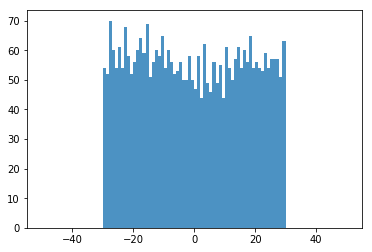

In [32]:
plt.hist(all_deltat1,bins=100,range=(-50,50),alpha=0.8);

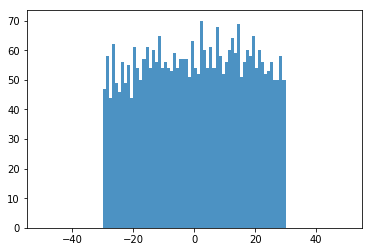

In [33]:
plt.hist(all_deltat2,bins=100,range=(-50,50),alpha=0.8);

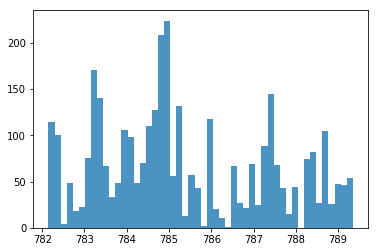

In [36]:
plt.hist(all_ps,bins=50,alpha=0.8);